<a href="https://colab.research.google.com/github/VKSi/2020_12_DataCompetitions_Course/blob/main/HW_2_ModelsAndMetrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Урок 2. Обзор основных алгоритмов машинного обучения, используемых в соревнованиях

В домашнем задании, будем обучать разные алгоритмы машинного обучения. Для этого, нужно предварительно зафиксировать схему валидации решения (можете выбрать любую, которую знаете). Выбранную схему валидации нужно использовать во всех задачах этого домашнего задания. Метрика качества - ROC AUC, целевая переменная - isFraud.
Ссылка на данные - https://drive.google.com/file/d/1gMEVl47pIoV1-AseB9doQ6DZNJrY3NkW/view?usp=sharing

Задание 1: отобрать только числовые признаки и обучить модель XGBoost с параметром booster = gbtree. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

Задание 2: обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 1.

Задание 4: для числовых признаков обучить модель LightGBM. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

Задание 5: обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 4.

Задание 6: обработать категориальные признаки встроенным методом в LightGBM. Выполнить задание 4. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 5.

Задание 7: для числовых признаков обучить модель CatBoost. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

Задание 8: обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 7.

Задание 9: обработать категориальные признаки встроенным методом в CatBoost. Выполнить задание 7. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 8.

Задание 10: построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.

#### Задание на повторение:
Задание не обязательно к выполнению, но очень рекомендуется для понимания набора данных, этот набор данных будет использован и для следующего домашнего задания.

Задание 1: Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.     

Задание 2: построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.     

Задание 3: построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.     

Задание 4: построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы.     

### Общая часть

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import warnings
warnings.simplefilter('ignore')

Загрузим данные

In [ ]:
train = pd.read_csv("assignment_2_train.csv")
test = pd.read_csv("assignment_2_test.csv")

Проверим размерность датасетов

In [ ]:
print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 180000 rows, 394 cols
test.shape = 100001 rows, 394 cols


Проверим различие в фитчах (должны различаться только на таргет):

In [ ]:
set(train.columns) - set(test.columns)

set()

Очевидно тестовая выборка является валидационной, так как целевая переменная не исключена

Создадим объединенный сет (без таргета на трейне) для анализа общих характеристик:

In [ ]:
union = pd.concat([train, test], axis=0, ignore_index=True)
union.shape

(280001, 394)

In [ ]:
union.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=394)

##### Разобьем данные по типам

In [ ]:
union.dtypes.value_counts()

float64    376
object      14
int64        4
dtype: int64

In [ ]:
REST_FEATURES = train.columns

In [ ]:
INITIAL_FEATURES = REST_FEATURES.copy()

In [ ]:
ID = 'TransactionID'
REST_FEATURES = list(set(REST_FEATURES) - set([ID]))

In [ ]:
union[ID].nunique() == union.shape[0]

True

In [ ]:
TARGET = 'isFraud'
REST_FEATURES = list(set(REST_FEATURES) - set([TARGET]))

In [ ]:
NUMERICAL_FEATURES = train[REST_FEATURES].select_dtypes(include=[np.number]).columns.to_list()
print(f"count of NUMERICAL_FEATURES {len(NUMERICAL_FEATURES)}")
REST_FEATURES = list(set(REST_FEATURES) - set(NUMERICAL_FEATURES))

count of NUMERICAL_FEATURES 378


In [ ]:
train[REST_FEATURES].dtypes

M6               object
M3               object
M8               object
card4            object
M4               object
M2               object
M1               object
M5               object
R_emaildomain    object
M9               object
P_emaildomain    object
card6            object
ProductCD        object
M7               object
dtype: object

In [ ]:
for f in REST_FEATURES:
    print('*'*20, '\n', f, '\n', '*'*20)
    print(union[f].value_counts())

******************** 
 M6 
 ********************
F    98456
T    84194
Name: M6, dtype: int64
******************** 
 M3 
 ********************
T    102027
F     27108
Name: M3, dtype: int64
******************** 
 M8 
 ********************
F    55757
T    32580
Name: M8, dtype: int64
******************** 
 card4 
 ********************
visa                182649
mastercard           87645
american express      5565
discover              3317
Name: card4, dtype: int64
******************** 
 M4 
 ********************
M0    87110
M2    28107
M1    22764
Name: M4, dtype: int64
******************** 
 M2 
 ********************
T    116083
F     13052
Name: M2, dtype: int64
******************** 
 M1 
 ********************
T    129128
F         7
Name: M1, dtype: int64
******************** 
 M5 
 ********************
F    58338
T    46947
Name: M5, dtype: int64
******************** 
 R_emaildomain 
 ********************
gmail.com           31713
hotmail.com         14119
anonymous.com       1211

In [ ]:
CATEGORICAL_FEATURES = REST_FEATURES

In [ ]:
REST_FEATURES = None

##### Посмотрим на таргет

In [ ]:
train[TARGET].value_counts()/train.shape[0]

0    0.971439
1    0.028561
Name: isFraud, dtype: float64

In [ ]:
test[TARGET].value_counts()/test.shape[0]

0    0.96196
1    0.03804
Name: isFraud, dtype: float64

Явный дисбаланс

##### Проверим наличие пропусков

In [ ]:
union.loc[:, union.isnull().sum() > 0].isnull().sum()

card2      4287
card3       819
card4       825
card5      2253
card6       824
          ...  
V335     225231
V336     225231
V337     225231
V338     225231
V339     225231
Length: 331, dtype: int64

Text(0.5, 0, 'Missing Observations Count')

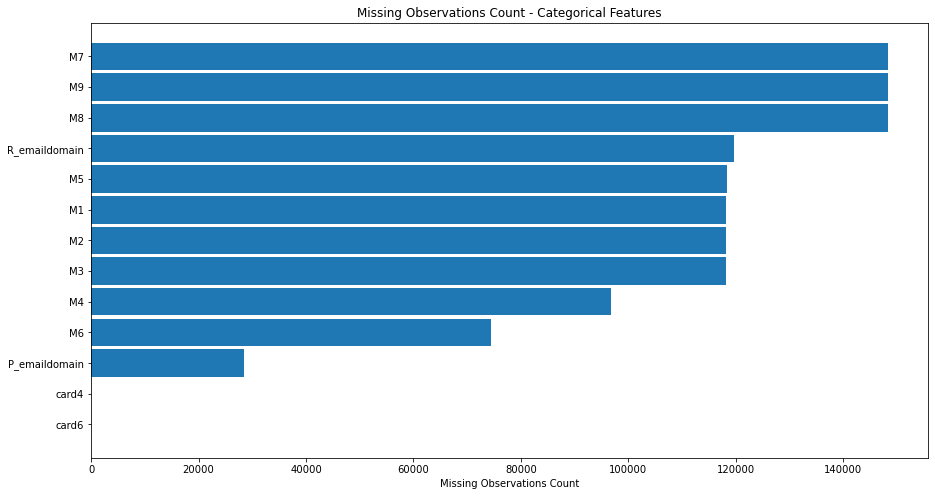

In [ ]:
missing_values = train[CATEGORICAL_FEATURES].isnull().sum(axis=0).reset_index()
missing_values.columns = ['column_name', 'missing_count']
missing_values = missing_values.loc[missing_values['missing_count']>0]
missing_values = missing_values.sort_values(by='missing_count')

ind = np.arange(missing_values.shape[0])
fig, axes = plt.subplots(figsize=(15, 8))
rects = axes.barh(ind, missing_values.missing_count.values, height=0.9)
axes.set_yticks(ind)
axes.set_yticklabels(missing_values.column_name.values, rotation='horizontal')
axes.set_title("Missing Observations Count - Categorical Features")
axes.set_xlabel("Missing Observations Count")

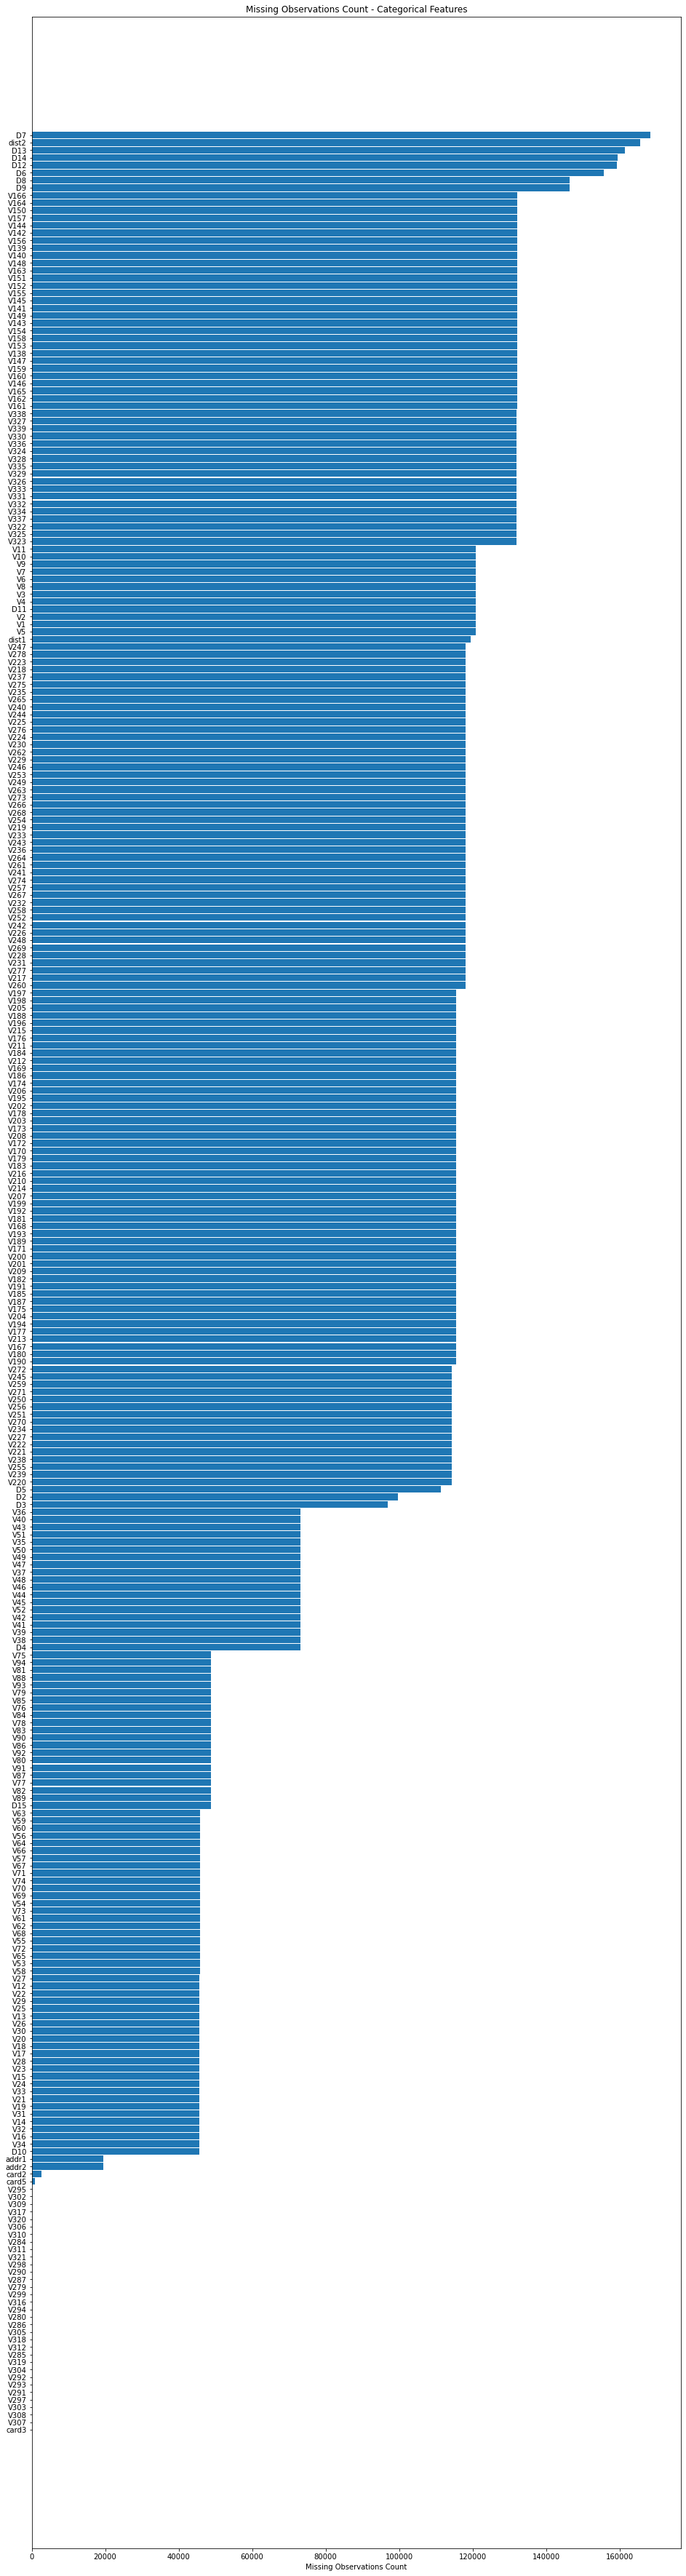

In [ ]:
missing_values = train[NUMERICAL_FEATURES].isnull().sum(axis=0).reset_index()
missing_values.columns = ['column_name', 'missing_count']
missing_values = missing_values[missing_values['missing_count']>0]
missing_values = missing_values.sort_values(by='missing_count')

ind = np.arange(missing_values.shape[0])
fig, axes = plt.subplots(figsize=(16, 64))
rects = axes.barh(ind, missing_values.missing_count.values, height=0.9)
axes.set_yticks(ind)
axes.set_yticklabels(missing_values.column_name.values, rotation='horizontal')
axes.set_title("Missing Observations Count - Categorical Features")
axes.set_xlabel("Missing Observations Count")
plt.show()

In [ ]:
f'Максимальный объем пропусков {union.loc[:, union.isnull().sum() > 0].isnull().sum().max()/union.shape[0]*100:.2f}%'

'Максимальный объем пропусков 93.67%'

In [ ]:
f'Количество признаков с пропусками > 20%  = {union.loc[:, union.isnull().sum() > union.shape[0]*0.2].shape[1]}'

'Количество признаков с пропусками > 20%  = 233'

С пропусками явная беда

### Сначала выполним Задание на повторение:

#### Задание 1:     
Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.   

Попробуем разобраться с тем, что представляет из себя это поле

In [ ]:
feature = 'TransactionDT'

In [ ]:
union[feature].nunique() / union.shape[0]

0.965560837282724

In [ ]:
train[feature].nunique() / train.shape[0]

0.9636666666666667

In [ ]:
test[feature].nunique() / test.shape[0]

0.9689703102968971

Время транзакций не уникально, есть транзакции, совершенные одновременно

In [ ]:
union[feature].min()

86400

In [ ]:
union[feature].max()

10091550

In [ ]:
union[feature].head(20).values

array([86400, 86401, 86469, 86499, 86506, 86510, 86522, 86529, 86535,
       86536, 86549, 86555, 86564, 86585, 86596, 86618, 86620, 86668,
       86725, 86730], dtype=int64)

In [ ]:
df = pd.DataFrame(union[feature])
df['DT_str'] = df[feature].astype(str)
df['DT_str_len'] = df['DT_str'].str.len()
df.head()

,TransactionDT,DT_str,DT_str_len
0,86400,86400,5
1,86401,86401,5
2,86469,86469,5
3,86499,86499,5
4,86506,86506,5


In [ ]:
df.loc[df['DT_str_len'] == 6, feature].head(20).values

array([100000, 100024, 100045, 100060, 100066, 100079, 100085, 100121,
       100159, 100169, 100179, 100189, 100189, 100204, 100237, 100290,
       100307, 100336, 100364, 100376], dtype=int64)

In [ ]:
df.loc[df['DT_str_len'] == 6, feature].tail(20).values

array([999216, 999233, 999411, 999448, 999483, 999502, 999558, 999605,
       999625, 999638, 999662, 999680, 999695, 999755, 999776, 999782,
       999831, 999837, 999861, 999894], dtype=int64)

К сожалению, предположение о том что этот признак является простой комбинацией даты и времени не подтверждается.     
Например, если в 86400 8 - июль, 6 - 6-е число, 4 - часы, 0 - минуты, 0 -секунды,     
то 999894 не объяснимо: 9-сентябрь, 9 - число, 9 - часы, 8 - минуты, 94 -НЕ секунды (

Придется расслабиться и работать с тем, что есть

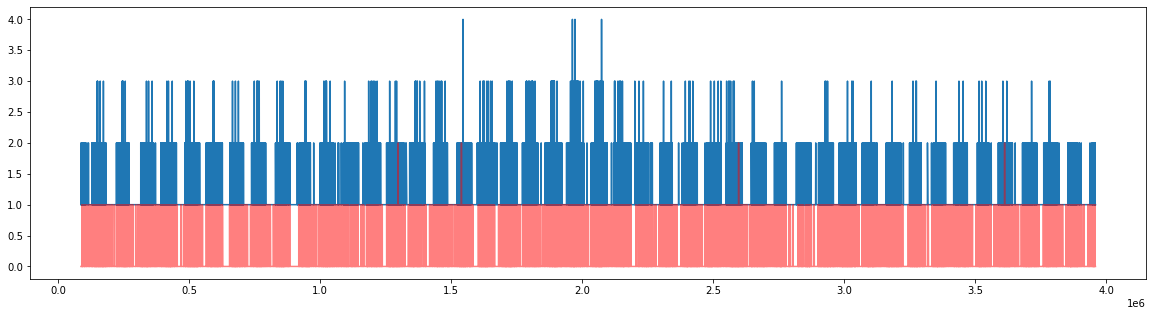

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(train[feature].value_counts().sort_index())
plt.plot(train[[feature, TARGET]].groupby(feature).agg('sum').sort_index(), color='r', alpha = 0.5)
plt.show()

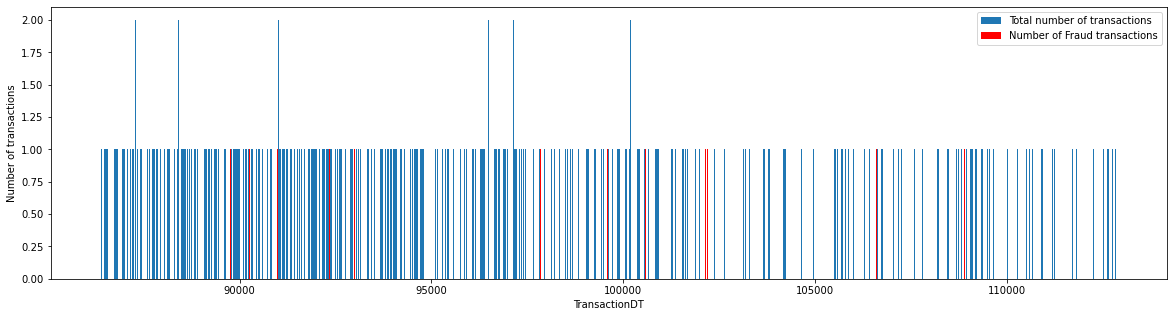

In [ ]:
plt.figure(figsize=(20, 5))
M = 0
N = 1000
wt = (N - M)/100
wf = (N - M)/50
indexes = train[feature].value_counts().sort_index()[M:N].index
plt.bar(x=indexes, height = train[feature].value_counts().sort_index()[M:N], width=wt, label='Total number of transactions')
plt.bar(x=indexes, height = (train[[feature, TARGET]].groupby(feature).agg('sum').sort_index().loc[indexes, TARGET]).values,
        width=wf,  color='r', label = 'Number of Fraud transactions')
plt.xlabel(f'{feature}')
plt.ylabel('Number of transactions')
plt.legend()
plt.show()

In [ ]:
import seaborn as sns
from scipy.stats import ks_2samp

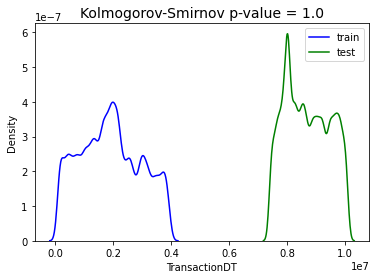

In [ ]:
train_data, test_data = train[feature].copy(), test[feature].copy()
sns.kdeplot(train_data, color="blue", label="train")
sns.kdeplot(test_data, color="green", label="test")

plt.title(f'Kolmogorov-Smirnov p-value = {round(ks_2samp(train_data, test_data)[0], 4)}', fontsize=14)
plt.legend()
plt.show()

Тестовая выборка имеет бОльшее время транзакций. Транзакции совершены позже    
Лично мне кажется, что каждая транзакция может рассматриваться как независимое событие ВНЕ зависимости от предыдущих. Однако, чтобы исключить лик информации, лучше на всякий случай для валидации пользоваться валидацией, применяемой для ТаймСерий - данные тестовой выборки (в том числе при кроссвалидации) не должны быть с временем меньшем, чем максимум в тренировочной выборке.

#### Задание 2:       
построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.

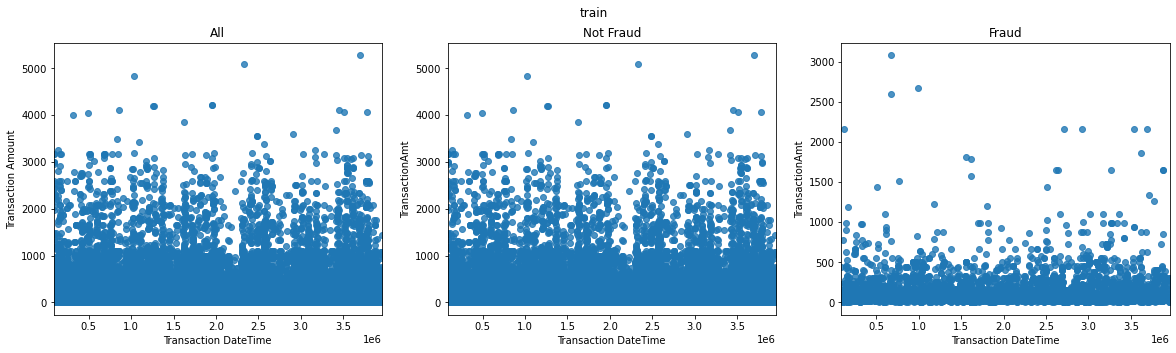

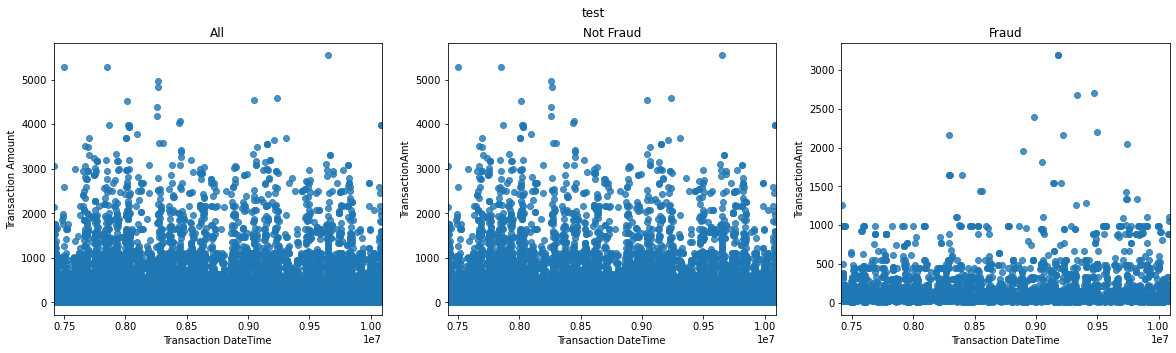

In [ ]:
for i, data in enumerate(['train', 'test']):
    plt.figure(figsize=(20, 5))
    plt.subplot(f'131')
    sns.regplot(
        x='TransactionDT',
        y='TransactionAmt',
        data=eval(data),
        scatter=True,
        fit_reg=True
    )
    plt.title('All')
    plt.ylabel('Transaction Amount')
    plt.xlabel('Transaction DateTime')
    
    plt.subplot(f'132')
    filter = (eval(data)[TARGET] == 0)
    sns.regplot(
        x='TransactionDT',
        y='TransactionAmt',
        data=eval(data)[filter],
        scatter=True,
        fit_reg=True
    )
    plt.xlabel('Transaction DateTime')
    plt.title('Not Fraud')
    
    plt.subplot(f'133')
    filter = (eval(data)[TARGET] == 1)
    sns.regplot(
        x='TransactionDT',
        y='TransactionAmt',
        data=eval(data)[filter],
        scatter=True,
        fit_reg=True
    )
    plt.xlabel('Transaction DateTime')
    plt.title('Fraud')
    

    plt.suptitle(data)
    plt.show()

NB! Не пойму, почему выдает не в sns дизайне и без регрессии (((

Видно, что суммы мошеннических транзакций меньше, чем суммы обычных транзакций. Однако, скаттерплот зависимости суммы транзакции от времени - не лучшая визуализация, чтобы увидеть этот эффект.     
Что можно увидеть имеено из этих визуализаций, я, если честно, не понял.Никакой видимой зависимости суммы от времмени не видно

#### Задание 3: 
построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы. 

In [ ]:
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

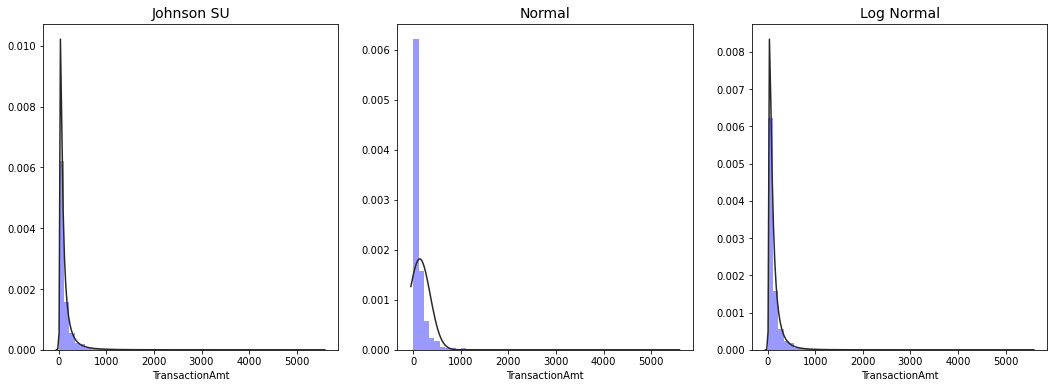

In [ ]:
feature = 'TransactionAmt'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].set_title("Johnson SU", fontsize=14)
sns.distplot(union[feature], kde=False, color="blue", fit=st.johnsonsu, ax=axes[0])

axes[1].set_title("Normal", fontsize=14)
sns.distplot(union[feature], kde=False, color="blue", fit=st.norm, ax=axes[1])

axes[2].set_title("Log Normal", fontsize=14)
sns.distplot(union[feature], kde=False, color="blue", fit=st.lognorm, ax=axes[2])

plt.show()

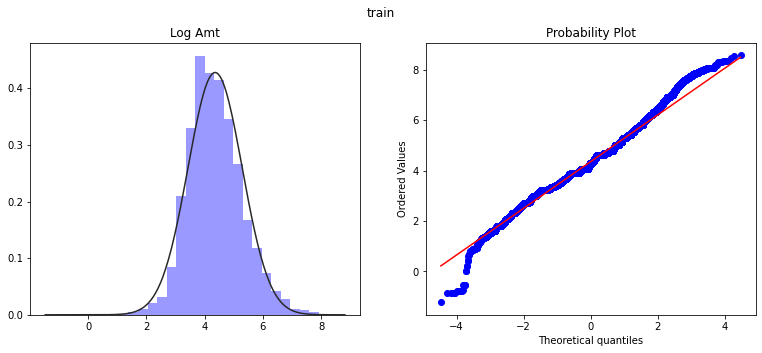

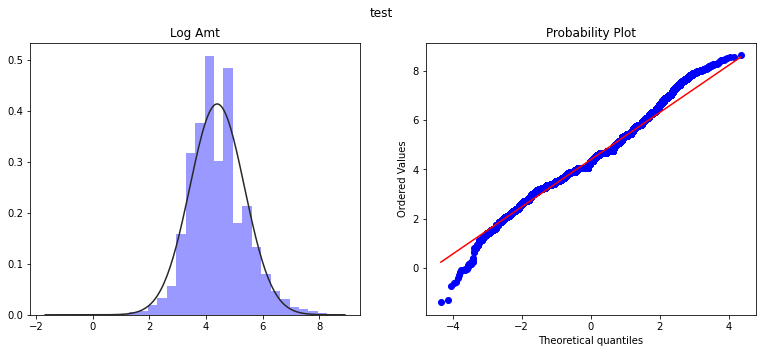

In [ ]:
for data in['train', 'test']:
    log_Amt = np.log(eval(data)[feature].values)
    fig = plt.figure(figsize=(13, 5))
    plt.subplot(121)
    sns.distplot(log_Amt, bins=30, kde=False, color="blue", fit=st.norm)
    plt.title('Log Amt')

    plt.subplot(122)
    probplot(log_Amt, plot=plt)
    plt.suptitle(data)
    plt.show()

Не то, чобы очень похоже на логнормальное, но все-же больше чем на нормальное

#### Задание 4:
построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы. 

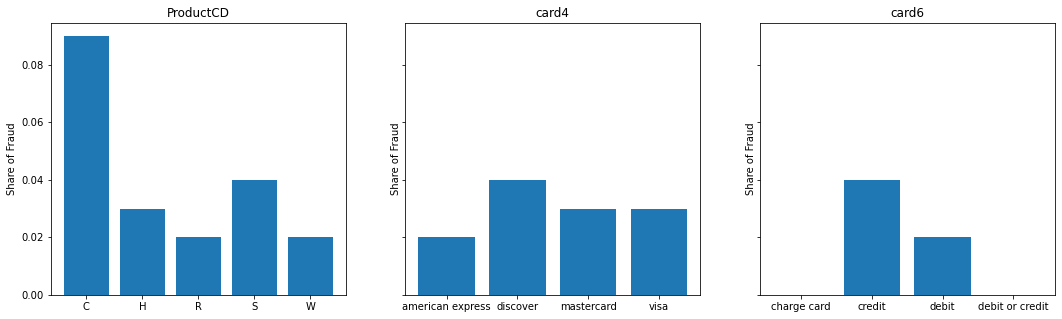

In [ ]:
features = ['ProductCD', 'card4', 'card6']
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for i, feature in enumerate(features):

    a = (train[[feature, TARGET]].groupby(feature).agg('sum').sort_index().loc[:, TARGET]).values
    b = train[feature].value_counts().sort_index().values
    l = train[feature].value_counts().sort_index().index
    axes[i].bar(x = l, height = (a/b).round(2))
    axes[i].set_ylabel('Share of Fraud')
    axes[i].set_title(feature)

plt.show()

Доля мошеннических транзакций зависит от категорий для всех трех признаков.    
Ярче всего это выражено для ProductCD (C) и для card6

### Основное задание:

Подготовим общую обработку категориальных признаков, которая понадобится во многих заданиях:

In [ ]:
BINARY_FEATURES = [f for f in CATEGORICAL_FEATURES if union[f].nunique() < 3]
REST_FEATURES = list(set(CATEGORICAL_FEATURES) - set(BINARY_FEATURES))
BINARY_FEATURES

['M6', 'M3', 'M8', 'M2', 'M1', 'M5', 'M9', 'M7']

In [ ]:
for f in BINARY_FEATURES:
    print('*'*20, '\n', f, '\n', '*'*20)
    print(union[f].value_counts())

******************** 
 M6 
 ********************
F    98456
T    84194
Name: M6, dtype: int64
******************** 
 M3 
 ********************
T    102027
F     27108
Name: M3, dtype: int64
******************** 
 M8 
 ********************
F    55757
T    32580
Name: M8, dtype: int64
******************** 
 M2 
 ********************
T    116083
F     13052
Name: M2, dtype: int64
******************** 
 M1 
 ********************
T    129128
F         7
Name: M1, dtype: int64
******************** 
 M5 
 ********************
F    58338
T    46947
Name: M5, dtype: int64
******************** 
 M9 
 ********************
T    75005
F    13332
Name: M9, dtype: int64
******************** 
 M7 
 ********************
F    76383
T    11951
Name: M7, dtype: int64


Заменим в бинарных признаках Т на 1 и F на 0

In [ ]:
for data in [union, train, test]:
    for f in BINARY_FEATURES:
        data.loc[data[f] == 'T', f] = 1
        data.loc[data[f] == 'F', f] = 0
        data[f] = data[f].astype(np.number)

In [ ]:
for f in BINARY_FEATURES:
    print('*'*20, '\n', f, '\n', '*'*20)
    print(union[f].value_counts())

******************** 
 M6 
 ********************
0.0    98456
1.0    84194
Name: M6, dtype: int64
******************** 
 M3 
 ********************
1.0    102027
0.0     27108
Name: M3, dtype: int64
******************** 
 M8 
 ********************
0.0    55757
1.0    32580
Name: M8, dtype: int64
******************** 
 M2 
 ********************
1.0    116083
0.0     13052
Name: M2, dtype: int64
******************** 
 M1 
 ********************
1.0    129128
0.0         7
Name: M1, dtype: int64
******************** 
 M5 
 ********************
0.0    58338
1.0    46947
Name: M5, dtype: int64
******************** 
 M9 
 ********************
1.0    75005
0.0    13332
Name: M9, dtype: int64
******************** 
 M7 
 ********************
0.0    76383
1.0    11951
Name: M7, dtype: int64


In [ ]:
TO_DUMMIES = [f for f in REST_FEATURES if union[f].nunique() < 6]
for f in TO_DUMMIES:
    print('*'*20, '\n', f, '\n', '*'*20)
    print(union[f].value_counts())

******************** 
 card4 
 ********************
visa                182649
mastercard           87645
american express      5565
discover              3317
Name: card4, dtype: int64
******************** 
 M4 
 ********************
M0    87110
M2    28107
M1    22764
Name: M4, dtype: int64
******************** 
 card6 
 ********************
debit              201146
credit              77998
debit or credit        22
charge card            11
Name: card6, dtype: int64
******************** 
 ProductCD 
 ********************
W    191581
C     33650
R     25019
H     24736
S      5015
Name: ProductCD, dtype: int64


In [ ]:
for f in TO_DUMMIES:
    union = pd.concat([union, pd.get_dummies(union[f], prefix=f'{f}')], axis=1)
    # union = union.drop(f, axis='columns')

In [ ]:
for f in TO_DUMMIES:
    test = pd.concat([test, pd.get_dummies(test[f], prefix=f'{f}')], axis=1)
    # test = test.drop(f, axis='columns')
    train = pd.concat([train, pd.get_dummies(train[f], prefix=f'{f}')], axis=1)
    # train = train.drop(f, axis='columns')

In [ ]:
train['M4_M0'].head()

0    0
1    1
2    1
3    1
4    0
Name: M4_M0, dtype: uint8

In [ ]:
REST_FEATURES = list(set(REST_FEATURES) - set(TO_DUMMIES))
REST_FEATURES

['P_emaildomain', 'R_emaildomain']

In [ ]:
for f in REST_FEATURES:
    print('*'*20, '\n', f, '\n', '*'*20)
    print(union[f].value_counts())

******************** 
 P_emaildomain 
 ********************
gmail.com           107277
yahoo.com            46916
hotmail.com          22165
anonymous.com        18812
aol.com              13334
comcast.net           4107
icloud.com            2866
outlook.com           2311
msn.com               2105
att.net               1841
sbcglobal.net         1519
live.com              1438
verizon.net           1401
ymail.com             1123
bellsouth.net         1001
me.com                 849
cox.net                775
yahoo.com.mx           768
optonline.net          523
charter.net            469
live.com.mx            370
rocketmail.com         320
mail.com               256
mac.com                248
earthlink.net          246
gmail                  228
outlook.es             209
roadrunner.com         165
juno.com               154
hotmail.es             144
embarqmail.com         142
aim.com                140
windstream.net         138
frontier.com           128
twc.com               

Оставшиеся два признака связаны с электронными адресами и имеют большую размерность.

In [ ]:
((union['P_emaildomain'].value_counts()/union['P_emaildomain'].count())[:5]).sum()

0.8831547291287221

In [ ]:
((union['R_emaildomain'].value_counts()/union['R_emaildomain'].count())[:5]).sum()

0.8737905742821472

Первые пять значений признаков покрывают почти 90% всего пространства (крое пропущенных значений).      
Объединим все остальные признаки в один и сделаем one-hot encoding

In [ ]:
for f in REST_FEATURES:
    keep = list(union[f].value_counts()[:5].index)
    union.loc[~union[f].isin(keep) , f] = 'others'
    union = pd.concat([union, pd.get_dummies(union[f], prefix=f'{f}')], axis=1)
    # union = union.drop(f, axis='columns')
    
    train.loc[~train[f].isin(keep), f] = 'others'
    train = pd.concat([train, pd.get_dummies(train[f], prefix=f'{f}')], axis=1)
    # train = train.drop(f, axis='columns')
    
    test.loc[~test[f].isin(keep), f] = 'others'
    test = pd.concat([test, pd.get_dummies(test[f], prefix=f'{f}')], axis=1)
    # test = test.drop(f, axis='columns')

In [ ]:
train['R_emaildomain_others'].head()

0    1
1    1
2    1
3    1
4    1
Name: R_emaildomain_others, dtype: uint8

In [ ]:
DROPPED_FEATURES = TO_DUMMIES + REST_FEATURES
DROPPED_FEATURES

['card4', 'M4', 'card6', 'ProductCD', 'P_emaildomain', 'R_emaildomain']

In [ ]:
NEW_FEATURES = list(set(train.columns) - set(INITIAL_FEATURES) - set(DROPPED_FEATURES))
NEW_FEATURES            

['ProductCD_W',
 'R_emaildomain_hotmail.com',
 'card4_discover',
 'card6_debit or credit',
 'P_emaildomain_anonymous.com',
 'ProductCD_R',
 'R_emaildomain_gmail.com',
 'ProductCD_C',
 'ProductCD_H',
 'P_emaildomain_yahoo.com',
 'R_emaildomain_others',
 'card4_american express',
 'card6_debit',
 'card4_mastercard',
 'R_emaildomain_aol.com',
 'card6_charge card',
 'P_emaildomain_hotmail.com',
 'R_emaildomain_anonymous.com',
 'P_emaildomain_aol.com',
 'M4_M1',
 'M4_M2',
 'card6_credit',
 'P_emaildomain_gmail.com',
 'P_emaildomain_others',
 'R_emaildomain_yahoo.com',
 'M4_M0',
 'ProductCD_S',
 'card4_visa']

In [ ]:
NEW_CATEGORICAL_FEATURES = BINARY_FEATURES + NEW_FEATURES
NEW_CATEGORICAL_FEATURES

['M6',
 'M3',
 'M8',
 'M2',
 'M1',
 'M5',
 'M9',
 'M7',
 'ProductCD_W',
 'R_emaildomain_hotmail.com',
 'card4_discover',
 'card6_debit or credit',
 'P_emaildomain_anonymous.com',
 'ProductCD_R',
 'R_emaildomain_gmail.com',
 'ProductCD_C',
 'ProductCD_H',
 'P_emaildomain_yahoo.com',
 'R_emaildomain_others',
 'card4_american express',
 'card6_debit',
 'card4_mastercard',
 'R_emaildomain_aol.com',
 'card6_charge card',
 'P_emaildomain_hotmail.com',
 'R_emaildomain_anonymous.com',
 'P_emaildomain_aol.com',
 'M4_M1',
 'M4_M2',
 'card6_credit',
 'P_emaildomain_gmail.com',
 'P_emaildomain_others',
 'R_emaildomain_yahoo.com',
 'M4_M0',
 'ProductCD_S',
 'card4_visa']

In [ ]:
set(test.columns) - set(NUMERICAL_FEATURES) - set([ID]) - set([TARGET]) - set(NEW_CATEGORICAL_FEATURES) - set(DROPPED_FEATURES)

set()

In [ ]:
set(train.columns) - set(NUMERICAL_FEATURES) - set([ID]) - set([TARGET]) - set(NEW_CATEGORICAL_FEATURES) - set(DROPPED_FEATURES)

set()

Приготовим тренировочные и валидационные данные

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, f1_score, recall_score, precision_score

In [ ]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [ ]:
def DT_split(data, train_size):
    dtf = 'TransactionDT'
    n_train = int(data.shape[0]*train_size)
    train_ind = data.sort_values(dtf)[:n_train].index
    test_ind = data.sort_values(dtf)[n_train:].index
    return data.loc[train_ind, :], data.loc[test_ind, :]

In [ ]:
X_train_t, X_test_t = (data.drop([ID, TARGET], axis='columns') for data in DT_split(train, 0.8))

In [ ]:
X_train_t.shape

(144000, 420)

In [ ]:
X_test_t.shape

(36000, 420)

In [ ]:
y_train, y_test = (data[TARGET] for data in DT_split(train, 0.8))

In [ ]:
y_train.shape

(144000,)

In [ ]:
y_test.shape

(36000,)

#### Задание 1:
отобрать только числовые признаки и обучить модель XGBoost с параметром booster = gbtree. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [ ]:
X_test = X_test_t[NUMERICAL_FEATURES]
X_train = X_train_t[NUMERICAL_FEATURES]

In [ ]:
import xgboost as xgb

In [ ]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "class_weight":"balanced", 
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [ ]:
dtrain = xgb.DMatrix(
    data=X_train, label=y_train
)
dvalid = xgb.DMatrix(
    data=X_test, label=y_test
)

In [ ]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=300,
    early_stopping_rounds=50,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=10,
    maximize=True
)

[22:46:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.61546	valid-auc:0.62643
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[10]	train-auc:0.74551	valid-auc:0.74568
[20]	train-auc:0.82948	valid-auc:0.83130
[30]	train-auc:0.85843	valid-auc:0.84243
[40]	train-auc:0.87125	valid-auc:0.84827
[50]	train-auc:0.88110	valid-auc:0.85701
[60]	train-auc:0.88808	valid-auc:0.86855
[70]	train-auc:0.89224	valid-auc:0.87334
[80]	train-auc:0.89443	valid-auc:0.87464
[90]	train-auc:0.89686	valid-auc:0.87554
[100]	train-auc:0.89884	valid-auc:0.87711
[1

In [ ]:
y_train_pred_prob = model.predict(dtrain)
y_test_pred_prob = model.predict(dvalid)

Если нужно максимизировать какой-либо другой параметр, можно поработать с отсечением.     
Например, из отчета видно, что recall очень низкий, но именно он чаще всего интересует при работе с мошенническими операциями.

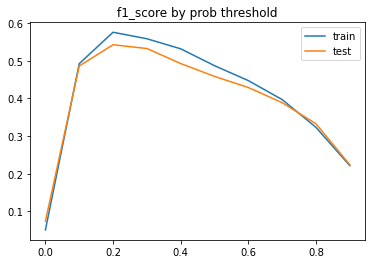

In [ ]:
metric = f1_score
# metric = recall_score
x = np.array(range(0, 10, 1))/10
f1_train = []
f1_test = []
for th in x:
    y_train_pred = y_train_pred_prob > th
    y_test_pred = y_test_pred_prob > th
    f1_train.append(metric(y_train, y_train_pred))
    f1_test.append(metric(y_test, y_test_pred))
plt.plot(x, f1_train, label='train')
plt.plot(x, f1_test, label='test')
plt.title(f'{metric.__name__} by prob threshold')
plt.legend()
plt.show()

In [ ]:
th = 0.2
y_train_pred = y_train_pred_prob > th
y_test_pred = y_test_pred_prob > th
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    140243
           1       0.68      0.50      0.58      3757

    accuracy                           0.98    144000
   macro avg       0.83      0.75      0.78    144000
weighted avg       0.98      0.98      0.98    144000

TEST

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     34616
           1       0.65      0.47      0.54      1384

    accuracy                           0.97     36000
   macro avg       0.81      0.73      0.76     36000
weighted avg       0.97      0.97      0.97     36000

CONFUSION MATRIX

col_0    False  True 
isFraud              
0        34260    356
1          736    648


In [ ]:
y_t_p = []
y_v_p = []

In [ ]:
y_t_p.append(y_train_pred_prob)
y_v_p.append(y_test_pred_prob)

#### Задание 2:
обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 1.

Обработка проведена в подготовительной части

In [ ]:
X_test = X_test_t[NUMERICAL_FEATURES + NEW_CATEGORICAL_FEATURES]
X_train = X_train_t[NUMERICAL_FEATURES + NEW_CATEGORICAL_FEATURES]

In [ ]:
dtrain = xgb.DMatrix(
    data=X_train, label=y_train
)
dvalid = xgb.DMatrix(
    data=X_test, label=y_test
)

In [ ]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=300,
    early_stopping_rounds=50,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=10,
    maximize=True
)

[22:46:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.61546	valid-auc:0.62643
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[10]	train-auc:0.74551	valid-auc:0.74568
[20]	train-auc:0.83002	valid-auc:0.83165
[30]	train-auc:0.86412	valid-auc:0.84770
[40]	train-auc:0.87875	valid-auc:0.85344
[50]	train-auc:0.88835	valid-auc:0.86306
[60]	train-auc:0.89545	valid-auc:0.87097
[70]	train-auc:0.90027	valid-auc:0.87900
[80]	train-auc:0.90369	valid-auc:0.88186
[90]	train-auc:0.90648	valid-auc:0.88394
[100]	train-auc:0.90862	valid-auc:0.88623
[1

Результат улучшился на 1% по сравнению с обработкой без категориальных признаков

In [ ]:
y_train_pred_prob = model.predict(dtrain)
y_test_pred_prob = model.predict(dvalid)

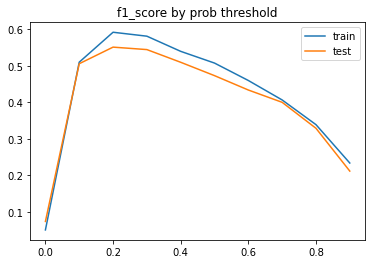

In [ ]:
metric = f1_score
# metric = recall_score
x = np.array(range(0, 10, 1))/10
f1_train = []
f1_test = []
for th in x:
    y_train_pred = y_train_pred_prob > th
    y_test_pred = y_test_pred_prob > th
    f1_train.append(metric(y_train, y_train_pred))
    f1_test.append(metric(y_test, y_test_pred))
plt.plot(x, f1_train, label='train')
plt.plot(x, f1_test, label='test')
plt.title(f'{metric.__name__} by prob threshold')
plt.legend()
plt.show()

In [ ]:
th = 0.2
y_train_pred = y_train_pred_prob > th
y_test_pred = y_test_pred_prob > th
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    140243
           1       0.68      0.52      0.59      3757

    accuracy                           0.98    144000
   macro avg       0.83      0.76      0.79    144000
weighted avg       0.98      0.98      0.98    144000

TEST

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     34616
           1       0.64      0.49      0.55      1384

    accuracy                           0.97     36000
   macro avg       0.81      0.74      0.77     36000
weighted avg       0.97      0.97      0.97     36000

CONFUSION MATRIX

col_0    False  True 
isFraud              
0        34229    387
1          710    674


In [ ]:
y_t_p.append(y_train_pred_prob)
y_v_p.append(y_test_pred_prob)

#### Задание 4:
для числовых признаков обучить модель LightGBM. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [ ]:
import lightgbm as lgb

In [ ]:
X_test = X_test_t[NUMERICAL_FEATURES]
X_train = X_train_t[NUMERICAL_FEATURES]

In [ ]:
params = {
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 1000,
    "n_jobs": 4,
    "max_depth": 4,
    "reg_lambda": 100,
    "class_weight":"balanced", 
    "seed": 27
}

In [ ]:
dtrain = lgb.Dataset(
    data=X_train, label=y_train
)
dvalid = lgb.Dataset(
    data=X_test, label=y_test
)

model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=2000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=100
)

Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.868189	valid_1's auc: 0.845817
[200]	training's auc: 0.878307	valid_1's auc: 0.855233
[300]	training's auc: 0.884861	valid_1's auc: 0.864707
[400]	training's auc: 0.889459	valid_1's auc: 0.870389
[500]	training's auc: 0.892857	valid_1's auc: 0.874453
[600]	training's auc: 0.895749	valid_1's auc: 0.876974
[700]	training's auc: 0.898309	valid_1's auc: 0.878489
[800]	training's auc: 0.900899	valid_1's auc: 0.880079
[900]	training's auc: 0.903351	valid_1's auc: 0.881536
[1000]	training's auc: 0.905638	valid_1's auc: 0.882835
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.905638	valid_1's auc: 0.882835


NB! Не понятно, почему 1000 итераций, если num_boost_round = 2000?

Результат такой-же как XGBoost (может быть был бы лучше если бы поиск продолжился)

In [ ]:
y_train_pred_prob = model.predict(X_train)
y_test_pred_prob = model.predict(X_test)

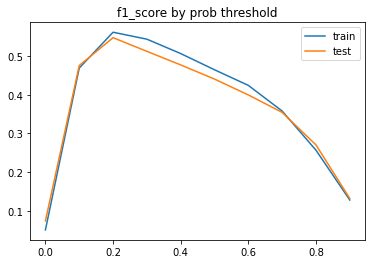

In [ ]:
metric = f1_score
# metric = recall_score
x = np.array(range(0, 10, 1))/10
f1_train = []
f1_test = []
for th in x:
    y_train_pred = y_train_pred_prob > th
    y_test_pred = y_test_pred_prob > th
    f1_train.append(metric(y_train, y_train_pred))
    f1_test.append(metric(y_test, y_test_pred))
plt.plot(x, f1_train, label='train')
plt.plot(x, f1_test, label='test')
plt.title(f'{metric.__name__} by prob threshold')
plt.legend()
plt.show()

In [ ]:
th = 0.2
y_train_pred = y_train_pred_prob > th
y_test_pred = y_test_pred_prob > th
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    140243
           1       0.67      0.48      0.56      3757

    accuracy                           0.98    144000
   macro avg       0.83      0.74      0.78    144000
weighted avg       0.98      0.98      0.98    144000

TEST

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     34616
           1       0.67      0.46      0.55      1384

    accuracy                           0.97     36000
   macro avg       0.82      0.73      0.77     36000
weighted avg       0.97      0.97      0.97     36000

CONFUSION MATRIX

col_0    False  True 
isFraud              
0        34302    314
1          744    640


Результат для recall и f1 хуже чем для XGB

In [ ]:
y_t_p.append(y_train_pred_prob)
y_v_p.append(y_test_pred_prob)

#### Задание 5:
обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 4.

In [ ]:
X_test = X_test_t[NUMERICAL_FEATURES + NEW_CATEGORICAL_FEATURES]
X_train = X_train_t[NUMERICAL_FEATURES + NEW_CATEGORICAL_FEATURES]

In [ ]:
dtrain = lgb.Dataset(
    data=X_train, label=y_train
)
dvalid = lgb.Dataset(
    data=X_test, label=y_test
)

model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=2000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=100
)

Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.87161	valid_1's auc: 0.847237
[200]	training's auc: 0.883146	valid_1's auc: 0.854595
[300]	training's auc: 0.889902	valid_1's auc: 0.862323
[400]	training's auc: 0.896003	valid_1's auc: 0.87105
[500]	training's auc: 0.900895	valid_1's auc: 0.876922
[600]	training's auc: 0.904521	valid_1's auc: 0.88105
[700]	training's auc: 0.907421	valid_1's auc: 0.884081
[800]	training's auc: 0.910007	valid_1's auc: 0.886282
[900]	training's auc: 0.91206	valid_1's auc: 0.887802
[1000]	training's auc: 0.91402	valid_1's auc: 0.889557
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.91402	valid_1's auc: 0.889557


NB! Не понятно, почему 1000 итераций, если num_boost_round = 2000?

Результат лучше чем без категориальных признаков, но возможно был бы лучше, если бы не остановился процесс обучения

In [ ]:
y_train_pred_prob = model.predict(X_train)
y_test_pred_prob = model.predict(X_test)

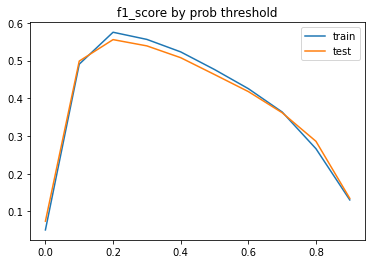

In [ ]:
metric = f1_score
# metric = recall_score
x = np.array(range(0, 10, 1))/10
f1_train = []
f1_test = []
for th in x:
    y_train_pred = y_train_pred_prob > th
    y_test_pred = y_test_pred_prob > th
    f1_train.append(metric(y_train, y_train_pred))
    f1_test.append(metric(y_test, y_test_pred))
plt.plot(x, f1_train, label='train')
plt.plot(x, f1_test, label='test')
plt.title(f'{metric.__name__} by prob threshold')
plt.legend()
plt.show()

In [ ]:
th = 0.2
y_train_pred = y_train_pred_prob > th
y_test_pred = y_test_pred_prob > th
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    140243
           1       0.66      0.51      0.58      3757

    accuracy                           0.98    144000
   macro avg       0.83      0.75      0.78    144000
weighted avg       0.98      0.98      0.98    144000

TEST

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     34616
           1       0.64      0.49      0.56      1384

    accuracy                           0.97     36000
   macro avg       0.81      0.74      0.77     36000
weighted avg       0.97      0.97      0.97     36000

CONFUSION MATRIX

col_0    False  True 
isFraud              
0        34240    376
1          707    677


Результат для recall и f1 такой же XGB c ручной обработкой категориальных признаков

In [ ]:
y_t_p.append(y_train_pred_prob)
y_v_p.append(y_test_pred_prob)

#### Задание 6:
обработать категориальные признаки встроенным методом в LightGBM. Выполнить задание 4. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 5.

In [ ]:
X_test = X_test_t[NUMERICAL_FEATURES + CATEGORICAL_FEATURES]
X_train = X_train_t[NUMERICAL_FEATURES + CATEGORICAL_FEATURES]

In [ ]:
cat_feat_num = [X_test.columns.get_loc(col) for col in CATEGORICAL_FEATURES]
cat_feat_num

[378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391]

In [ ]:
TO_ENCODING = X_train[CATEGORICAL_FEATURES].select_dtypes('object').columns.to_list()

In [ ]:
for f in TO_ENCODING:
    X_train[f] = X_train[f].astype('category')
    X_test[f] = X_test[f].astype('category')

In [ ]:
params['categorical_feature'] = cat_feat_num

In [ ]:
dtrain = lgb.Dataset(
    data=X_train, label=y_train
)
dvalid = lgb.Dataset(
    data=X_test, label=y_test
)

model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=2000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=100
)

Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.871558	valid_1's auc: 0.847309
[200]	training's auc: 0.88284	valid_1's auc: 0.854027
[300]	training's auc: 0.89046	valid_1's auc: 0.861587
[400]	training's auc: 0.89664	valid_1's auc: 0.870908
[500]	training's auc: 0.901538	valid_1's auc: 0.876875
[600]	training's auc: 0.905401	valid_1's auc: 0.880827
[700]	training's auc: 0.908264	valid_1's auc: 0.884082
[800]	training's auc: 0.910816	valid_1's auc: 0.886539
[900]	training's auc: 0.913197	valid_1's auc: 0.888277
[1000]	training's auc: 0.915154	valid_1's auc: 0.889464
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.915154	valid_1's auc: 0.889464


NB! Не понятно, почему 1000 итераций, если num_boost_round = 2000?

Результат не сильно отличается от "ручного", но возможно был бы лучше, если бы не остановился процесс обучения

In [ ]:
y_train_pred_prob = model.predict(X_train)
y_test_pred_prob = model.predict(X_test)

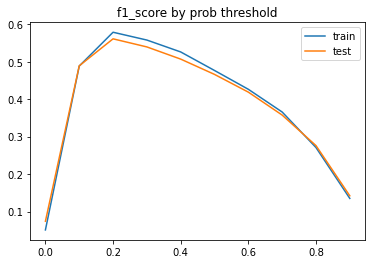

In [ ]:
metric = f1_score
# metric = recall_score
x = np.array(range(0, 10, 1))/10
f1_train = []
f1_test = []
for th in x:
    y_train_pred = y_train_pred_prob > th
    y_test_pred = y_test_pred_prob > th
    f1_train.append(metric(y_train, y_train_pred))
    f1_test.append(metric(y_test, y_test_pred))
plt.plot(x, f1_train, label='train')
plt.plot(x, f1_test, label='test')
plt.title(f'{metric.__name__} by prob threshold')
plt.legend()
plt.show()

In [ ]:
th = 0.2
y_train_pred = y_train_pred_prob > th
y_test_pred = y_test_pred_prob > th
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    140243
           1       0.67      0.51      0.58      3757

    accuracy                           0.98    144000
   macro avg       0.83      0.75      0.78    144000
weighted avg       0.98      0.98      0.98    144000

TEST

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     34616
           1       0.65      0.49      0.56      1384

    accuracy                           0.97     36000
   macro avg       0.82      0.74      0.77     36000
weighted avg       0.97      0.97      0.97     36000

CONFUSION MATRIX

col_0    False  True 
isFraud              
0        34252    364
1          702    682


Результат для recall и f1 такой же как для XGB при ручной обработке категориальных признаков

In [ ]:
y_t_p.append(y_train_pred_prob)
y_v_p.append(y_test_pred_prob)

#### Задание 7:
для числовых признаков обучить модель CatBoost. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [ ]:
import catboost as cb

In [ ]:
X_test = X_test_t[NUMERICAL_FEATURES]
X_train = X_train_t[NUMERICAL_FEATURES]

In [ ]:
train_pool = cb.Pool(X_train, y_train, cat_features=[])
valid_pool = cb.Pool(X_test, y_test, cat_features=[])

In [ ]:
cb_params = {
    "n_estimators": 1000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 100,
    "max_depth": 4,
    "reg_lambda": 100,
    "class_weights":[3, 97], 
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 27
}

In [ ]:
model = cb.CatBoostClassifier(**cb_params)
model.fit(train_pool, eval_set=[train_pool, valid_pool])

0:	test: 0.7833377	test1: 0.8030384	best: 0.8030384 (0)	total: 50.9ms	remaining: 50.8s
100:	test: 0.8711127	test1: 0.8514720	best: 0.8516348 (98)	total: 5.55s	remaining: 49.4s
200:	test: 0.8815847	test1: 0.8613844	best: 0.8613844 (200)	total: 11.1s	remaining: 44.3s
300:	test: 0.8879013	test1: 0.8669569	best: 0.8669569 (300)	total: 16.4s	remaining: 38.2s
400:	test: 0.8938589	test1: 0.8712364	best: 0.8712364 (400)	total: 21.8s	remaining: 32.6s
500:	test: 0.9040886	test1: 0.8787322	best: 0.8787322 (500)	total: 27.5s	remaining: 27.4s
600:	test: 0.9125493	test1: 0.8830770	best: 0.8830833 (599)	total: 33s	remaining: 21.9s
700:	test: 0.9185583	test1: 0.8860481	best: 0.8860481 (700)	total: 38.4s	remaining: 16.4s
800:	test: 0.9237970	test1: 0.8892155	best: 0.8892155 (800)	total: 44s	remaining: 10.9s
900:	test: 0.9281825	test1: 0.8917117	best: 0.8917117 (900)	total: 49.3s	remaining: 5.42s
999:	test: 0.9322296	test1: 0.8933585	best: 0.8933585 (999)	total: 54.9s	remaining: 0us

bestTest = 0.893358

Результаты без категориальных признаков лучше чем на всех других моделях даже с категориями

In [ ]:
y_train_pred_prob = model.predict_proba(X_train)
y_test_pred_prob = model.predict_proba(X_test)

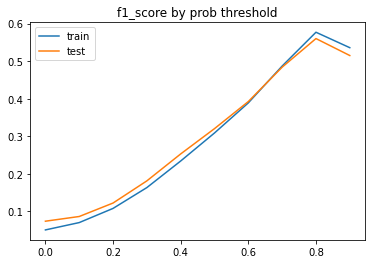

In [ ]:
metric = f1_score
# metric = recall_score
x = np.array(range(0, 10, 1))/10
f1_train = []
f1_test = []
for th in x:
    y_train_pred = y_train_pred_prob[:, 1] > th
    y_test_pred = y_test_pred_prob[:, 1] > th
    f1_train.append(metric(y_train, y_train_pred))
    f1_test.append(metric(y_test, y_test_pred))
plt.plot(x, f1_train, label='train')
plt.plot(x, f1_test, label='test')
plt.title(f'{metric.__name__} by prob threshold')
plt.legend()
plt.show()

In [ ]:
th = 0.78
y_train_pred = y_train_pred_prob[:, 1] > th
y_test_pred = y_test_pred_prob[:, 1] > th
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    140243
           1       0.56      0.58      0.57      3757

    accuracy                           0.98    144000
   macro avg       0.77      0.78      0.78    144000
weighted avg       0.98      0.98      0.98    144000

TEST

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     34616
           1       0.58      0.52      0.55      1384

    accuracy                           0.97     36000
   macro avg       0.78      0.75      0.77     36000
weighted avg       0.97      0.97      0.97     36000

CONFUSION MATRIX

col_0    False  True 
isFraud              
0        34102    514
1          663    721


Балансировка классов в соответствии с долей присутствия при тренинге модели дает не очень сбалансированные результаты. Можно через сетку подобрать более сбалансированные параметры 

In [ ]:
y_t_p.append(y_train_pred_prob[:, 1])
y_v_p.append(y_test_pred_prob[:, 1])

#### Задание 8:
обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 7.

In [ ]:
X_test = X_test_t[NUMERICAL_FEATURES + NEW_CATEGORICAL_FEATURES]
X_train = X_train_t[NUMERICAL_FEATURES + NEW_CATEGORICAL_FEATURES]

In [ ]:
train_pool = cb.Pool(X_train, y_train, cat_features=[])
valid_pool = cb.Pool(X_test, y_test, cat_features=[])

In [ ]:
model = cb.CatBoostClassifier(**cb_params)
model.fit(train_pool, eval_set=[train_pool, valid_pool])

0:	test: 0.7785517	test1: 0.7871885	best: 0.7871885 (0)	total: 54.4ms	remaining: 54.3s
100:	test: 0.8752228	test1: 0.8525939	best: 0.8527765 (98)	total: 5.53s	remaining: 49.2s
200:	test: 0.8865870	test1: 0.8619661	best: 0.8619661 (200)	total: 11.4s	remaining: 45.4s
300:	test: 0.8939439	test1: 0.8691638	best: 0.8691638 (300)	total: 17.7s	remaining: 41.1s
400:	test: 0.9004740	test1: 0.8744176	best: 0.8744176 (400)	total: 23.6s	remaining: 35.2s
500:	test: 0.9120118	test1: 0.8840091	best: 0.8840091 (500)	total: 29.8s	remaining: 29.7s
600:	test: 0.9212447	test1: 0.8900291	best: 0.8900291 (600)	total: 35.8s	remaining: 23.7s
700:	test: 0.9278253	test1: 0.8937703	best: 0.8937703 (700)	total: 41.3s	remaining: 17.6s
800:	test: 0.9321023	test1: 0.8957379	best: 0.8957379 (800)	total: 46.8s	remaining: 11.6s
900:	test: 0.9364778	test1: 0.8975534	best: 0.8976344 (899)	total: 52.3s	remaining: 5.75s
999:	test: 0.9398617	test1: 0.8992686	best: 0.8992867 (998)	total: 58s	remaining: 0us

bestTest = 0.8992

Результат не изменился

In [ ]:
y_train_pred_prob = model.predict_proba(X_train)
y_test_pred_prob = model.predict_proba(X_test)

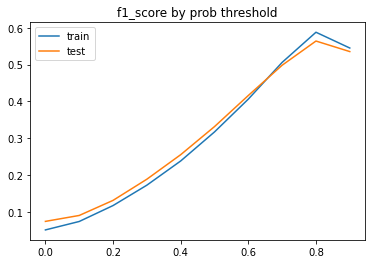

In [ ]:
metric = f1_score
# metric = recall_score
x = np.array(range(0, 10, 1))/10
f1_train = []
f1_test = []
for th in x:
    y_train_pred = y_train_pred_prob[:, 1] > th
    y_test_pred = y_test_pred_prob[:, 1] > th
    f1_train.append(metric(y_train, y_train_pred))
    f1_test.append(metric(y_test, y_test_pred))
plt.plot(x, f1_train, label='train')
plt.plot(x, f1_test, label='test')
plt.title(f'{metric.__name__} by prob threshold')
plt.legend()
plt.show()

In [ ]:
th = 0.78
y_train_pred = y_train_pred_prob[:, 1] > th
y_test_pred = y_test_pred_prob[:, 1] > th
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    140243
           1       0.55      0.60      0.57      3757

    accuracy                           0.98    144000
   macro avg       0.77      0.79      0.78    144000
weighted avg       0.98      0.98      0.98    144000

TEST

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     34616
           1       0.58      0.54      0.56      1384

    accuracy                           0.97     36000
   macro avg       0.78      0.76      0.77     36000
weighted avg       0.97      0.97      0.97     36000

CONFUSION MATRIX

col_0    False  True 
isFraud              
0        34063    553
1          632    752


In [ ]:
y_t_p.append(y_train_pred_prob[:, 1])
y_v_p.append(y_test_pred_prob[:, 1])

#### Задание 9:
обработать категориальные признаки встроенным методом в CatBoost. Выполнить задание 7. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 8.

In [ ]:
X_test = X_test_t[NUMERICAL_FEATURES + CATEGORICAL_FEATURES]
X_train = X_train_t[NUMERICAL_FEATURES + CATEGORICAL_FEATURES]

In [ ]:
X_test[CATEGORICAL_FEATURES] = X_test[CATEGORICAL_FEATURES].astype('str')
X_train[CATEGORICAL_FEATURES] = X_train[CATEGORICAL_FEATURES].astype('str')

In [ ]:
train_pool = cb.Pool(X_train, y_train, cat_features=CATEGORICAL_FEATURES)
valid_pool = cb.Pool(X_test, y_test, cat_features=CATEGORICAL_FEATURES)

In [ ]:
model = cb.CatBoostClassifier(**cb_params)
model.fit(train_pool, eval_set=[train_pool, valid_pool])

0:	test: 0.7763204	test1: 0.8037035	best: 0.8037035 (0)	total: 216ms	remaining: 3m 36s
100:	test: 0.8738228	test1: 0.8525986	best: 0.8525986 (100)	total: 19.5s	remaining: 2m 53s
200:	test: 0.8856810	test1: 0.8599088	best: 0.8599088 (200)	total: 38.1s	remaining: 2m 31s
300:	test: 0.8916427	test1: 0.8650350	best: 0.8651166 (297)	total: 56.5s	remaining: 2m 11s
400:	test: 0.8980367	test1: 0.8715747	best: 0.8715747 (400)	total: 1m 15s	remaining: 1m 53s
500:	test: 0.9100904	test1: 0.8805823	best: 0.8806402 (498)	total: 1m 35s	remaining: 1m 34s
600:	test: 0.9188470	test1: 0.8853814	best: 0.8853814 (600)	total: 1m 54s	remaining: 1m 15s
700:	test: 0.9249460	test1: 0.8891193	best: 0.8891193 (700)	total: 2m 12s	remaining: 56.7s
800:	test: 0.9298513	test1: 0.8917857	best: 0.8917857 (800)	total: 2m 31s	remaining: 37.6s
900:	test: 0.9341373	test1: 0.8940740	best: 0.8941074 (899)	total: 2m 50s	remaining: 18.7s
999:	test: 0.9379697	test1: 0.8958061	best: 0.8958061 (999)	total: 3m 9s	remaining: 0us

be

Ручная обработка дала лучший результат.

In [ ]:
y_train_pred_prob = model.predict_proba(X_train)
y_test_pred_prob = model.predict_proba(X_test)

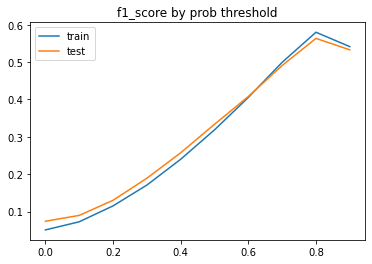

In [ ]:
metric = f1_score
# metric = recall_score
x = np.array(range(0, 10, 1))/10
f1_train = []
f1_test = []
for th in x:
    y_train_pred = y_train_pred_prob[:, 1] > th
    y_test_pred = y_test_pred_prob[:, 1] > th
    f1_train.append(metric(y_train, y_train_pred))
    f1_test.append(metric(y_test, y_test_pred))
plt.plot(x, f1_train, label='train')
plt.plot(x, f1_test, label='test')
plt.title(f'{metric.__name__} by prob threshold')
plt.legend()
plt.show()

In [ ]:
th = 0.78
y_train_pred = y_train_pred_prob[:, 1] > th
y_test_pred = y_test_pred_prob[:, 1] > th
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    140243
           1       0.55      0.60      0.57      3757

    accuracy                           0.98    144000
   macro avg       0.77      0.79      0.78    144000
weighted avg       0.98      0.98      0.98    144000

TEST

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     34616
           1       0.57      0.53      0.55      1384

    accuracy                           0.97     36000
   macro avg       0.78      0.76      0.77     36000
weighted avg       0.97      0.97      0.97     36000

CONFUSION MATRIX

col_0    False  True 
isFraud              
0        34070    546
1          647    737


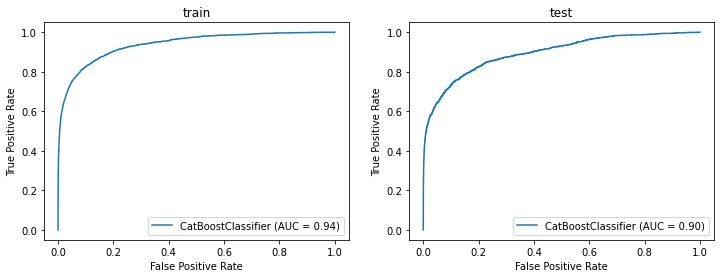

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].set_title('train')
plot_roc_curve(model, X_train, y_train, ax = axes[0])
axes[1].set_title('test')
plot_roc_curve(model, X_test, y_test, ax = axes[1])
plt.show()

In [ ]:
y_t_p.append(y_train_pred_prob[:, 1])
y_v_p.append(y_test_pred_prob[:, 1])

#### Задание 10:
построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.

In [ ]:
from sklearn.metrics import plot_roc_curve, roc_curve, auc

In [ ]:
def plot_ROC_train_test(y_train, y_train_pred_prob, y_test, y_test_pred_prob):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].set_title('train')
    fpr, tpr, fresholds = roc_curve(y_train, y_train_pred_prob)
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    axes[0].legend(loc = 'lower right')
    axes[0].plot([0, 1], [0, 1],'r--')
    axes[0].set_xlim([0, 1])
    axes[0].set_ylim([0, 1])
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_xlabel('False Positive Rate')

    axes[1].set_title('test')
    fpr, tpr, fresholds = roc_curve(y_test, y_test_pred_prob)
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    axes[1].legend(loc = 'lower right')
    axes[1].plot([0, 1], [0, 1],'r--')
    axes[1].set_xlim([0, 1])
    axes[1].set_ylim([0, 1])
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_xlabel('False Positive Rate')

    plt.show()

Model №1


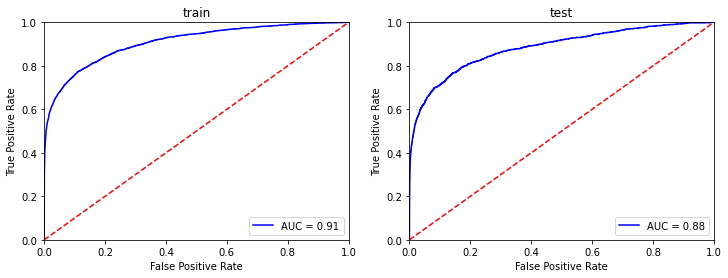

Model №2


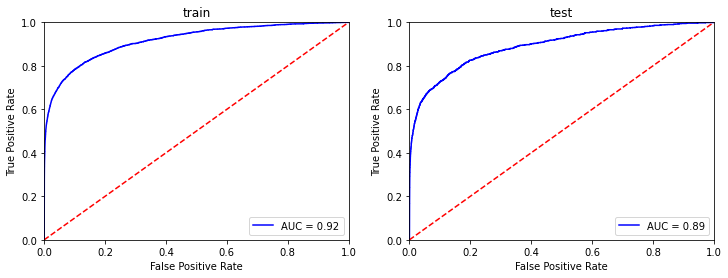

Model №3


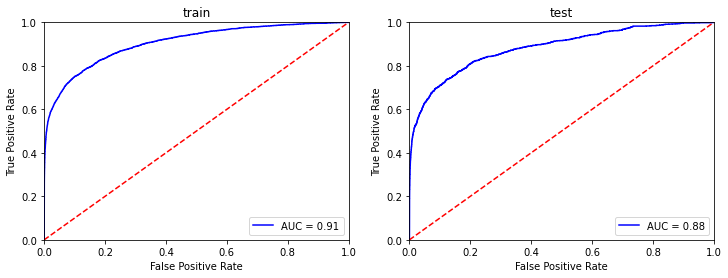

Model №4


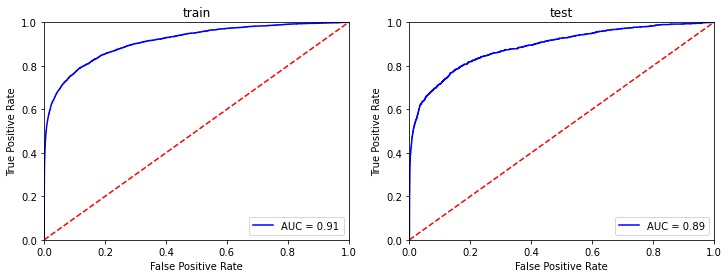

Model №5


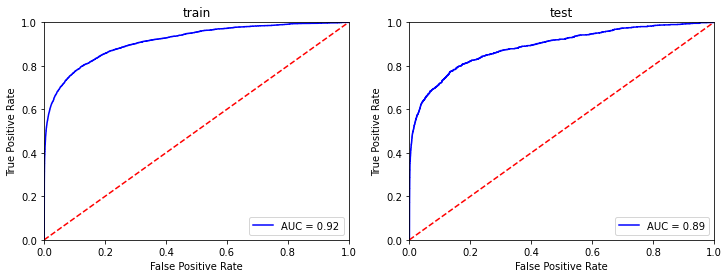

Model №6


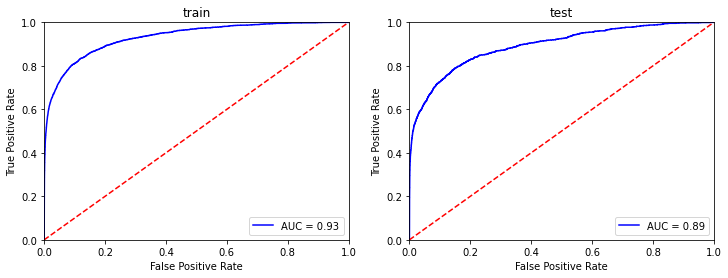

Model №7


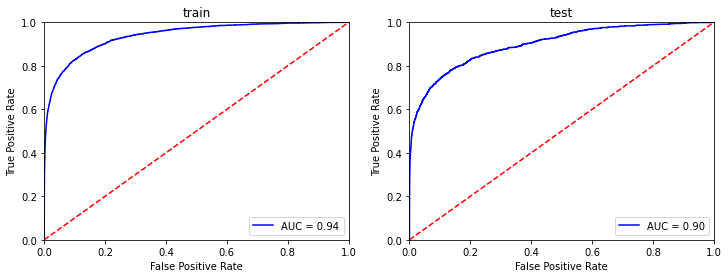

Model №8


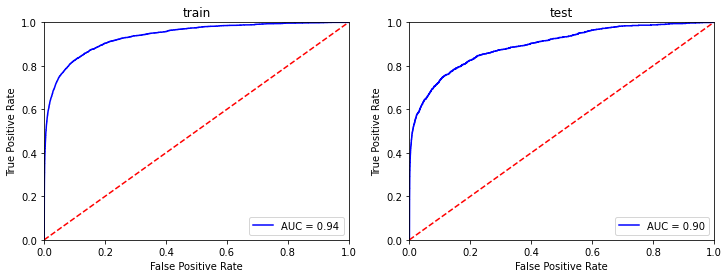

In [ ]:
for i in range(len(y_t_p)):
    print(f'Model №{i+1}')
    plot_ROC_train_test(y_train, y_t_p[i], y_test, y_v_p[i])

Лучшие результаты, как уже обозначалось выше, дал catboost с использование категориальных признаков.     
При этом ручная автоматическая обработка признаков для lightgb оказалась чуть лучше ручной, а для catboost незначительно хуже.